In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
xset = np.load('../1-prepro/xset.npy')
yset = np.load('../1-prepro/yset.npy')

xset.shape, yset.shape

((34120, 2, 3750), (34120,))

In [257]:
def get_y(yset):
    
    outs=[]
    for y in yset:
        if y >=65: out = 1
        #if (y>=65) & (y<85): out= 2
        #if (y>=40) & (y<65): out= 1
        if y <60: out=0
            
        outs.append(out)
    outs = np.array(outs)
    return outs


In [258]:
data_y = get_y(yset)

(array([29225.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4895.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

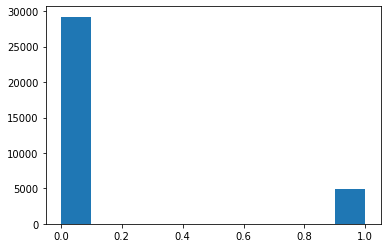

In [259]:
plt.hist(data_y)

In [263]:
def get_data(x, y, n=2500):
    x0 = x[y==0]
    x1 = x[y==1]
    #x2 = x[y==2]
    #x3 = x[y==3]
    
    x0 = random.sample(list(x0), n)
    #x1 = random.sample(list(x1), n)
    x0 = np.array(x0)
    #x1 = np.array(x1)
    
    x_data = np.concatenate((x0, x1), axis=0)
    y_data = [0 for i in range(n)]+[1 for i in range(len(x1))]
    #+[2 for i in range(len(x2))]+[3 for i in range(len(x3))]
    y_data = np.array(y_data)
    return x_data, y_data

In [264]:
x_data, y_data = get_data(xset, data_y, n=6000)

In [265]:
x_data.shape, y_data.shape

((10895, 2, 3750), (10895,))

In [180]:
def plot_data_dist(x):
    x = x.reshape(x.shape[0]*x.shape[1])
    x[x>100]=100
    x[x<-100]=-100
    x = x.reshape(len(x), 1)
    plt.hist(x, bins=50, alpha=0.5)
    return x
from sklearn.preprocessing import StandardScaler 
def plot_scaled_dist(x):
    scaler = StandardScaler()
    scaler.fit(x)
    scaled = scaler.transform(x)
    plt.hist(scaled, bins=50, alpha=0.5)

    return scaled

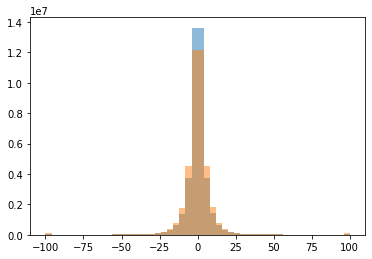

In [266]:
x0 = plot_data_dist(x_data[:,0])
x1 = plot_data_dist(x_data[:,1])

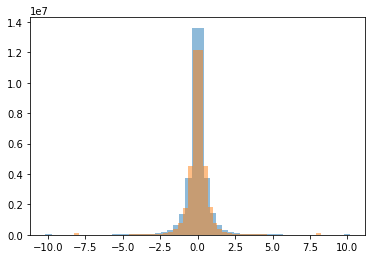

In [267]:
x0 = plot_scaled_dist(x0)
x1 = plot_scaled_dist(x1)

In [268]:
#x0_ = x0.reshape(34120, 1, 3750)
#x1_ = x1.reshape(34120, 1, 3750)
x0_ = x0.reshape(len(x_data), 3750, 1)
x1_ = x1.reshape(len(x_data), 3750, 1)
x0_.shape, x1_.shape

((10895, 3750, 1), (10895, 3750, 1))

In [269]:
data_x = np.concatenate((x0_, x1_), axis=2)
data_x.shape

(10895, 3750, 2)

In [271]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, y_data, test_size=0.15, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9260, 3750, 2), (1635, 3750, 2), (9260,), (1635,))

In [272]:
from tensorflow.keras import layers
def build_wavenet():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=[3750, 2]))
    for rate in (1,2,4,8):
        model.add(layers.Conv1D(filters=20, kernel_size=2, 
                                padding='causal', activation='relu', dilation_rate=rate))
    
    model.add(layers.AveragePooling1D(50, padding='same'))
    model.add(layers.Conv1D(20, 100, padding='same', activation='relu'))
    
    model.add(layers.Conv1D(1, 100, padding='same', activation='relu'))
    model.add(layers.AveragePooling1D(10, padding='same'))
    
    
    model.add(layers.Conv1D(4, 10, padding='same'))
    model.add(layers.AveragePooling1D(10, padding='same'))
    model.add(layers.Reshape(( 4, )))
    model.add(layers.Activation('softmax'))
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])    
    return model

In [273]:
model = build_wavenet()
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 3750, 20)          100       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 3750, 20)          820       
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 3750, 20)          820       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 3750, 20)          820       
_________________________________________________________________
average_pooling1d_80 (Averag (None, 75, 20)            0         
_________________________________________________________________
conv1d_278 (Conv1D)          (None, 75, 20)            40020     
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 75, 1)           

In [279]:
class_weights = np.array([0.68741815, 1])
                         #0.8576366 , 4.63653047, 4.63653047])
history = model.fit(x_train, y_train , 
                    batch_size=64, epochs=5, 
                    validation_split=0.2,
                    #class_weight=class_weights
                   
)

Train on 7408 samples, validate on 1852 samples
Epoch 1/5
7408/7408 [==============================] - 46s 6ms/sample - loss: 0.2425 - accuracy: 0.8966 - val_loss: 0.2648 - val_accuracy: 0.8839
Epoch 2/5
7408/7408 [==============================] - 46s 6ms/sample - loss: 0.2441 - accuracy: 0.8979 - val_loss: 0.2474 - val_accuracy: 0.8931
Epoch 3/5
7408/7408 [==============================] - 46s 6ms/sample - loss: 0.2611 - accuracy: 0.8870 - val_loss: 0.2612 - val_accuracy: 0.8866
Epoch 4/5
7408/7408 [==============================] - 46s 6ms/sample - loss: 0.2383 - accuracy: 0.9012 - val_loss: 0.2351 - val_accuracy: 0.9028
Epoch 5/5
7408/7408 [==============================] - 46s 6ms/sample - loss: 0.2344 - accuracy: 0.9017 - val_loss: 0.2348 - val_accuracy: 0.9001


In [275]:
model.evaluate(x_test, y_test)

1635/1635 [==============================] - 3s 2ms/sample - loss: 0.2785 - accuracy: 0.8789


[0.2784637144034791, 0.8788991]

In [276]:
y_pred = model.predict_classes(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

Text(33.0, 0.5, 'True')

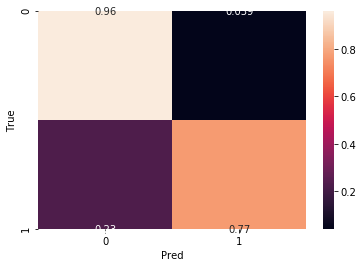

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel("Pred")
ax.set_ylabel("True")

In [278]:
cm

array([[0.96103896, 0.03896104],
       [0.2278481 , 0.7721519 ]])

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/Users/nibey/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
